<a href="https://colab.research.google.com/github/kutaydemiralay/Lane-Changing-Using-Controller-Design-with-Torque-Vectoring-and-Rear-Wheel-Steering/blob/main/LaneChange_with_RearWheelSteering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install numpy matplotlib cvxpy


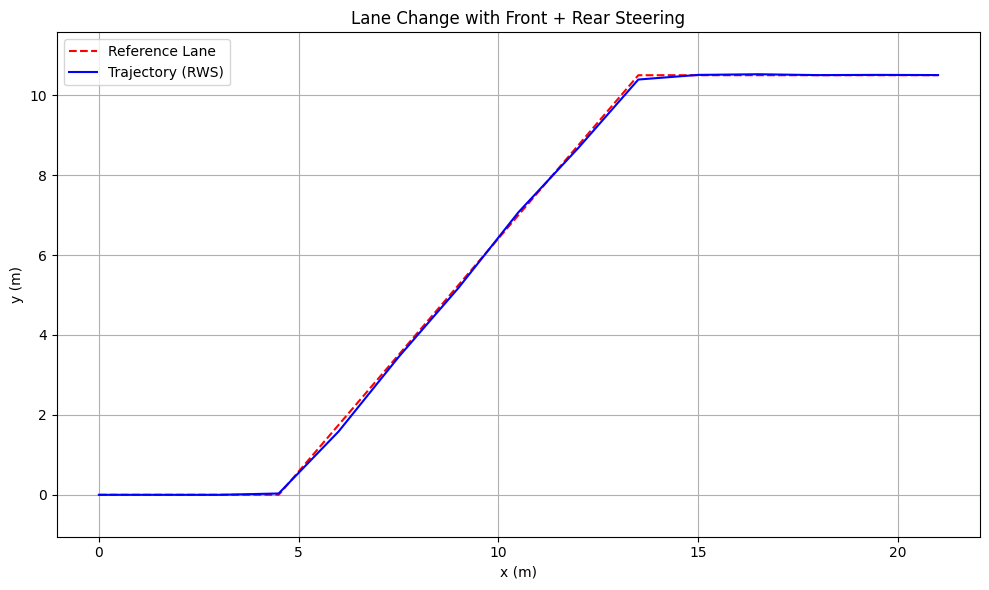

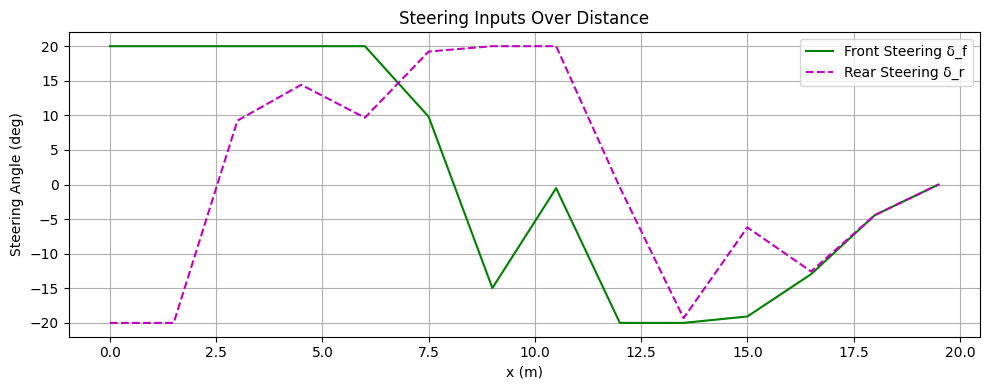

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

# === Parameters ===
N = 14
dt = 0.1
v_long = 15.0
a = 1.2
b = 1.3
m = 1500.0
Iz = 3000.0
Cf = 80000.0
Cr = 80000.0
delta_max = np.deg2rad(20)
w_delta = 0.1
w_delta_r = 0.1

# === Initial State ===
y0 = 0.0
psi0 = 0.0
vy0 = 0.0
r0 = 0.0

# === Reference Trajectory ===
x_ref = np.linspace(0, N * dt * v_long, N + 1)
y_ref = np.zeros(N + 1)
hold_steps = 3
transition_length = 9.0
y_final = 10.5

for k in range(hold_steps, N + 1):
    dx = x_ref[k] - x_ref[hold_steps]
    if dx <= transition_length:
        y_ref[k] = (dx / transition_length) * y_final
    else:
        y_ref[k] = y_final

# === Optimization Variables ===
vy = cp.Variable(N + 1)
r = cp.Variable(N + 1)
y = cp.Variable(N + 1)
psi = cp.Variable(N + 1)
delta_f = cp.Variable(N)
delta_r = cp.Variable(N)

# === Cost & Constraints ===
cost = 0
constraints = []

for k in range(N):
    A11 = -(2 * Cf + 2 * Cr) / (m * v_long)
    A12 = -v_long - (2 * Cf * a - 2 * Cr * b) / (m * v_long)
    A21 = -(2 * Cf * a - 2 * Cr * b) / (Iz * v_long)
    A22 = -(2 * Cf * a**2 + 2 * Cr * b**2) / (Iz * v_long)
    B1f = 2 * Cf / m
    B1r = 2 * Cr / m
    B2f = 2 * Cf * a / Iz
    B2r = -2 * Cr * b / Iz

    cost += 2 * cp.square(y[k+1] - y_ref[k+1])
    cost += w_delta * cp.square(delta_f[k])
    cost += w_delta_r * cp.square(delta_r[k])

    constraints += [
        vy[k+1] == vy[k] + dt * (A11 * vy[k] + A12 * r[k] + B1f * delta_f[k] + B1r * delta_r[k]),
        r[k+1] == r[k] + dt * (A21 * vy[k] + A22 * r[k] + B2f * delta_f[k] + B2r * delta_r[k]),
        y[k+1] == y[k] + dt * (vy[k] + v_long * psi[k]),
        psi[k+1] == psi[k] + dt * r[k],
        cp.abs(delta_f[k]) <= delta_max,
        cp.abs(delta_r[k]) <= delta_max,
    ]

constraints += [vy[0] == vy0, r[0] == r0, y[0] == y0, psi[0] == psi0]

# === Solve MPC ===
problem = cp.Problem(cp.Minimize(cost), constraints)
problem.solve()

# === Plot Results ===
plt.figure(figsize=(10, 6))
plt.plot(x_ref, y_ref, 'r--', label='Reference Lane')
plt.plot(x_ref, y.value, 'b-', label='Trajectory (RWS)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Lane Change with Front + Rear Steering')
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.tight_layout()
plt.show()

# === Plot Steering Angles ===
plt.figure(figsize=(10, 4))
plt.plot(x_ref[:-1], np.rad2deg(delta_f.value), 'g-', label='Front Steering δ_f')
plt.plot(x_ref[:-1], np.rad2deg(delta_r.value), 'm--', label='Rear Steering δ_r')
plt.xlabel('x (m)')
plt.ylabel('Steering Angle (deg)')
plt.title('Steering Inputs Over Distance')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [3]:
# === Compute Average Absolute Lateral Error ===
avg_abs_lateral_error = np.mean(np.abs(y.value - y_ref))
print(f"Average Absolute Lateral Error: {avg_abs_lateral_error:.4f} meters")


Average Absolute Lateral Error: 0.0410 meters
